In [1]:
import numpy as np
import pysindy as ps

from scipy.integrate import solve_ivp
from pysindy.utils import linear_damped_SHO, cubic_damped_SHO, van_der_pol, lotka

import matplotlib.pyplot as plt

from numpy import genfromtxt

import deepSI
from deepSI import System_data

import torch
from torch import nn
from torch.nn import functional as F

import csv
import os

from scipy.io import loadmat

import torch.nn.utils.prune as prune

## check utils
from utils import load_data, normalize

from matplotlib.colors import LinearSegmentedColormap

c:\Users\20173928\Miniconda3\envs\sindy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
x_data, u_data, y_data, th_data = load_data(pc=0)

In [3]:
train_samples = 1000000
val_samples   = 100000
x_train, u_train = x_data[:train_samples,:], u_data[:train_samples]
x_val,     u_val = x_data[train_samples:,:], u_data[train_samples:]

In [4]:
# BEST
x_data, u_data = x_train, u_train

x_data_n, n_n, n_d = normalize(x_data, all_cols=True, per_col=False,  method= "normalize")
u_data_n = (u_data-n_n)/n_d

# x_data_n, n_n, n_d = normalize(np.c_[x_data, u_data], all_cols=True, per_col=False,  method= "normalize")
# u_data_n = x_data_n[:,-1]
# x_data_n = x_data_n[:,:-1]

# x_data_s, s_n, s_d = normalize(x_data, all_cols=True, per_col=False, method="standardize")
# u_data_s = (u_data-s_n)/s_d

# x_data_n, n_n, n_d = normalize(x_data, all_cols=True, per_col=True,  method= "normalize")
# u_data_n, _, _ = normalize(u_data, all_cols=True, per_col=True,    method= "normalize")

# x_data_s, s_n, s_d = normalize(x_data, all_cols=True, per_col=True, method="standardize")
# u_data_s, _, _ = normalize(u_data, all_cols=True, per_col=True,  method= "standardize")

In [5]:
x_data = x_data_n
u_data = u_data_n

input  = x_data[:-1,:]
u_input = u_data[:-1]

output = x_data[1:,:]

# check if right data is selected
np.sum((input[1:,:]-output[:-1,:]))

0.0

In [6]:
# building theta matrix with only necesary features
# in this case [1 x1 x2 u np.sin(x1)]

Theta = np.c_[np.ones(input.shape[0]), input[:,0], input[:,1], u_input, np.sin(input[:,0])]

# normalized
# Theta, num, den = normalize(Theta, method="standardize")
# Theta, num, den = normalize(Theta, method= "normalize")

Theta.shape # should be 5

(999999, 5)

In [7]:
# output, num, den = normalize(output, all_cols=True, method= "standardize")
# output, num, den = normalize(output, all_cols=True, method= "normalize")

In [8]:
# validation

val_input, val_u_input  = x_val[:-1,:], u_val[:-1]
val_output              = x_val[1:,:]

# normalize
val_input   = (val_input - n_n)/n_d
val_u_input = (val_u_input-n_n)/n_d
val_output  = (val_output- n_n)/n_d

Theta_val  = np.c_[np.ones(val_input.shape[0]), val_input[:,0], val_input[:,1], val_u_input, np.sin(val_input[:,0])]

Theta_val_t  = torch.as_tensor(Theta_val).to(torch.float32)
val_output_t = torch.as_tensor(val_output).to(torch.float32)

In [9]:
def validation(x_in, x_out, criterion, model):
    model.eval()

    with torch.no_grad():
        output = model(x_in)
        val_loss = criterion(output, x_out)

    model.train()

    return val_loss, model

In [10]:
# converting necesary data to tensors
Theta_t  = torch.as_tensor(Theta).to(torch.float32)
output_t = torch.as_tensor(output).to(torch.float32)

In [11]:
class f_net(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super(f_net, self).__init__()
        
        self.layer = nn.Linear(n_in, n_out, bias=False)

    def forward(self, x):
        out = self.layer(x)
        return out

In [12]:
# loss function
def criterion(X_pred, X_true):
    return 1/2 * nn.functional.mse_loss(X_true, X_pred)

In [13]:
# seperate x1 and x2
output_t     =     output_t[:,1].unsqueeze(-1)
val_output_t = val_output_t[:,1].unsqueeze(-1)

In [14]:
output_t.shape

torch.Size([999999, 1])

In [15]:
# initialize model
n_in  = Theta_t.shape[-1]
n_out = output_t.shape[-1]

model = f_net(n_in, n_out)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5000
losses = []
val_losses = []

min_loss = 1

count = 0

for epo in range(epochs):
    pred = model(Theta_t)

    loss = criterion(pred, output_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().numpy())

    # validation
    val_loss, model = validation(Theta_val_t, val_output_t, criterion, model)
    val_losses.append(val_loss)

    if val_loss<min_loss:
        min_loss = loss
        best_param = [*model.parameters()][0].detach().numpy()
        best_epo = epo
        count = 0
    else:
        count += 1

    # if count == 10:
        # break

    if (epo%(epochs//10)==0 or epo==epochs-1) and epo != 0:
        epo_p = epo if epo != epochs-1 else epo+1
        print("Epoch {} train loss: {:.10f}, val loss: {:.10f}".format(epo_p, loss, val_loss))


Epoch 500 train loss: 0.0000000503, val loss: 0.0000000482
Epoch 1000 train loss: 0.0000000491, val loss: 0.0000000470
Epoch 1500 train loss: 0.0000000484, val loss: 0.0000000464
Epoch 2000 train loss: 0.0000000476, val loss: 0.0000000456
Epoch 2500 train loss: 0.0000000465, val loss: 0.0000000445
Epoch 3000 train loss: 0.0000000450, val loss: 0.0000000431
Epoch 3500 train loss: 0.0000000433, val loss: 0.0000000414
Epoch 4000 train loss: 0.0000000411, val loss: 0.0000000393
Epoch 4500 train loss: 0.0000000384, val loss: 0.0000000367
Epoch 5000 train loss: 0.0000000354, val loss: 0.0000000338


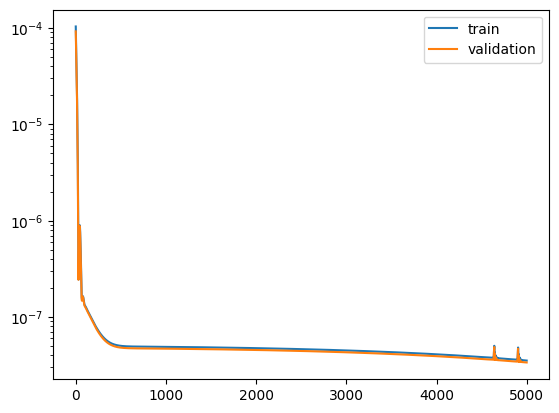

In [16]:
plt.semilogy(losses)
plt.semilogy(val_losses)
plt.legend(["train","validation"])
plt.show()

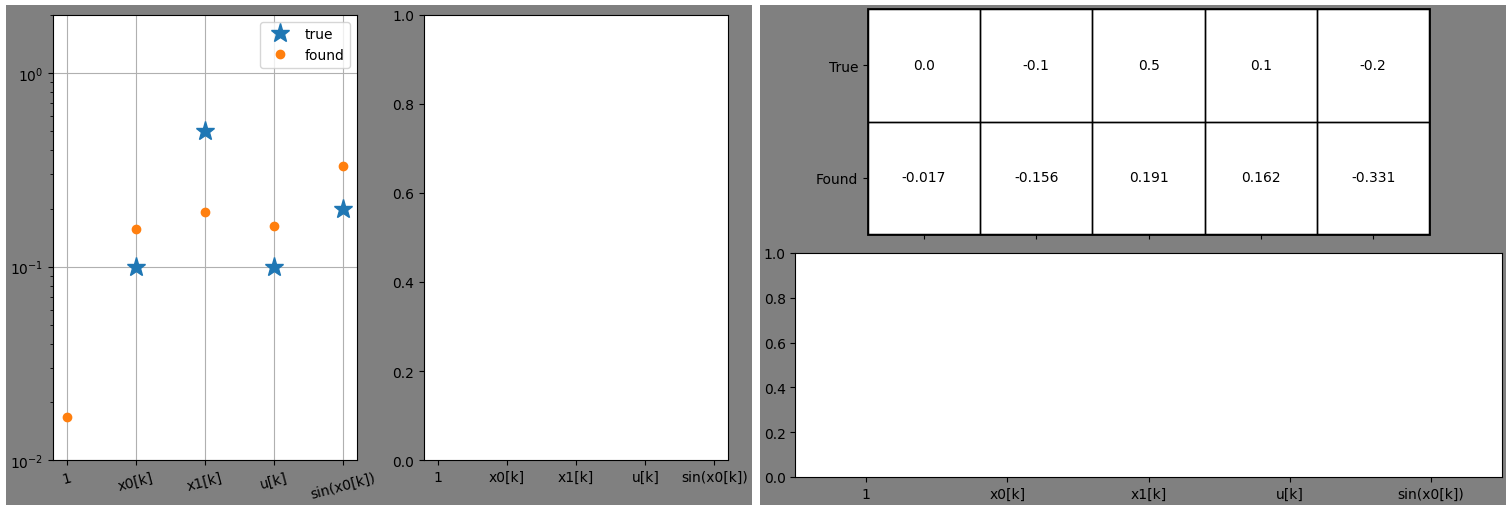

In [17]:
found = [*model.parameters()][0].detach().numpy()

true = np.array([[0, 0], [1, -0.1], [1, 0.5], [0, 0.1], [0, -0.2]])

x_labels = ["1", "x0[k]", "x1[k]", "u[k]", "sin(x0[k])"]

fig = plt.figure(layout='constrained', figsize=(15, 5))
subfigs = fig.subfigures(1, 2, wspace=0.01)

subfigs[0].set_facecolor('grey')
subfigs[1].set_facecolor('grey')

axsnest0 = subfigs[0].subplots(1, 2, sharex=True)
axsnest1 = subfigs[1].subplots(2, 1, sharex=True)

ax1, ax2 = axsnest0[0], axsnest0[1]

ax1.semilogy(np.abs(true[:,1]), "*", markersize=14)
ax1.semilogy(np.abs(found[0,:]), "o", markersize=6)
ax1.grid()
ax1.set_xticks(np.arange(0,len(x_labels),1))
ax1.set_xticklabels(x_labels, rotation=15)
ax1.set_ylim([1e-2, 2])
ax1.legend(["true","found"])

# ax2.semilogy(np.abs(true[:,1]), "*", markersize=14)
# ax2.semilogy(np.abs(found[1,:]), "o", markersize=6)
# ax2.set_xticks(np.arange(0,len(x_labels),1))
# ax2.set_xticklabels(x_labels, rotation=15)
# ax2.set_ylim([1e-2, 2])
# ax2.grid()
# ax2.legend(["true","found"])

# right side
ax1, ax2 = axsnest1[0], axsnest1[1]

data1 = np.vstack((true[:,1],found[0,:]))

cmap_white = LinearSegmentedColormap.from_list("white", [(1, 1, 1), (1, 1, 1)])

im = ax1.imshow(data1, cmap=cmap_white)

ax1.set_xticks(np.arange(data1.shape[1]), labels=x_labels)
ax1.set_yticks(np.arange(data1.shape[0]), labels=["True", "Found"])

for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        text = ax1.text(j, i, round(data1[i, j],3),
                       ha="center", va="center", color="k")
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=1)
        ax1.add_patch(rect)

ax1.patch.set_linewidth(2.0)        
ax1.patch.set_edgecolor('black')

# second
# data2 = np.vstack((true[:,1],found[1,:]))

# im = ax2.imshow(data2, cmap=cmap_white)

# ax2.set_xticks(np.arange(data2.shape[1]), labels=x_labels)
# ax2.set_yticks(np.arange(data2.shape[0]), labels=["True", "Found"])

# for i in range(data2.shape[0]):
#     for j in range(data2.shape[1]):
#         text = ax2.text(j, i, round(data2[i, j], 3),
#                        ha="center", va="center", color="k")
#         rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=1)
#         ax2.add_patch(rect)

# ax2.patch.set_linewidth(2.0)        
# ax2.patch.set_edgecolor('black')

plt.show()


In [18]:
# out_net = np.matmul(Theta, found.T)[0:100,:]

found =found[0]

# x1_l = []
x2_l = []
x2_t = []

for i in Theta[:100,:]:
  # x1 = found[0,0]*i[0]+found[0,1]*i[1]+found[0,2]*i[2]+found[0,3]*i[3]+found[0,4]*i[4]
  x2 = found[0]*i[0]+found[1]*i[1]+found[2]*i[2]+found[3]*i[3]+found[4]*i[4]
  x22 = true[0,1]*i[0]+true[1,1]*i[1]+true[2,1]*i[2]+true[3,1]*i[3]+true[4,1]*i[4]
  # x1_l.append(x1)
  x2_l.append(x2)
  x2_t.append(x22)

In [19]:
# plt.plot(out_net[:,0])
# plt.plot(x1_l,"*")
# # plt.plot(x2_l,"*")
# # plt.plot(x_data[0:10,:],"-o")
# plt.plot(x_data[1:101,0],"-o")


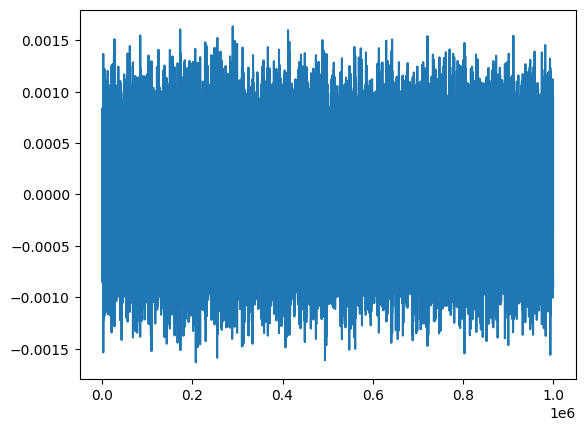

In [20]:
plt.plot(x_train[:,-1])

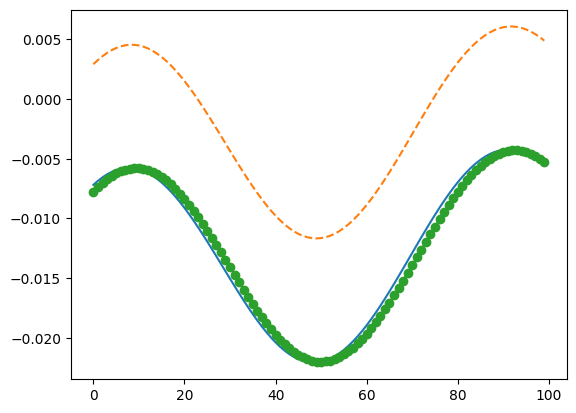

In [21]:
plt.plot(x2_l)
plt.plot(x2_t,"--")
plt.plot(x_data[:100,1],'-o')
# plt.plot(Theta[:100,3],"-o")